💥 爆倉! 時間: 2025-07-21 14:59:00, 價格: 0.5371, 淨值: -3.76, 維持保證金: 45.15


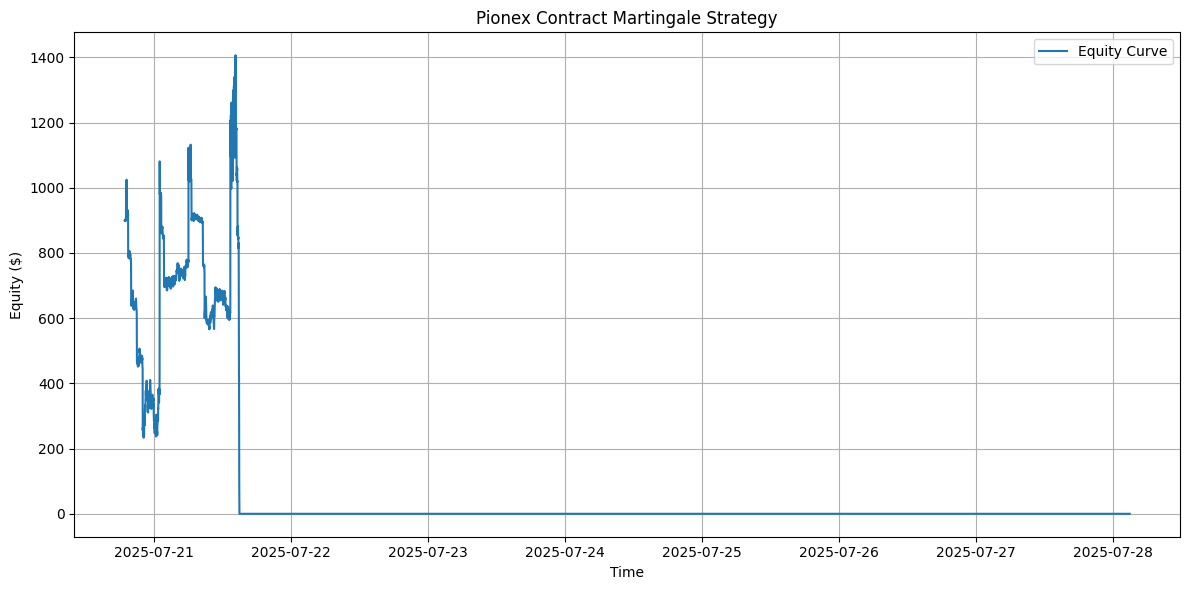


📊 回測統計：
Final Balance: 0.00
Total Return: -899.60
Max Drawdown: 1406.30
Sharpe Ratio: -0.18


In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ========== 1. Binance K線獲取 ==========
def get_binance_kline(symbol: str, interval: str, end_time: datetime, total_limit: int = 1000) -> pd.DataFrame:
    base_url = "https://api.binance.com/api/v3/klines"
    all_data = []
    end_timestamp = int(end_time.timestamp() * 1000)
    remaining = total_limit

    while remaining > 0:
        fetch_limit = min(1000, remaining)
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "endTime": end_timestamp,
            "limit": fetch_limit
        }

        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
        except Exception as e:
            print(f"Error fetching data: {e}")
            break

        data = response.json()
        if not data:
            break

        all_data = data + all_data
        end_timestamp = data[0][0] - 1
        remaining -= len(data)

    df = pd.DataFrame(all_data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df.sort_values("timestamp").reset_index(drop=True)


# ========== 2. 派網風格合約馬丁策略 ==========
class PionexMartinStrategy:
    def __init__(self, side='long', leverage=5, 
                 initial_margin=100, grid_pct=0.01, tp_pct=0.01, 
                 max_levels=10, scale_factor=1.1, initial_balance=1000,
                 fee_rate=0.0004, maintenance_margin_rate=0.005):
        self.fee_rate = fee_rate
        self.side = side
        self.leverage = leverage
        self.grid_pct = grid_pct
        self.tp_pct = tp_pct
        self.max_levels = max_levels
        self.scale_factor = scale_factor
        self.initial_margin = initial_margin
        self.initial_balance = initial_balance
        self.maintenance_margin_rate = maintenance_margin_rate

        self.reset()

    def reset(self):
        self.balance = self.initial_balance   # 可用餘額（現金）
        self.positions = []  # 入場價格清單
        self.qty_list = []   # 各檔位數量
        self.level = 0
        self.equity_history = []
        self.in_position = False
        self.liquidated = False  # 是否爆倉

    def on_price(self, price, timestamp):
        if self.liquidated:
            # 爆倉後不再交易，繼續記錄淨值
            self._record_equity(price, timestamp)
            return

        if not self.in_position:
            self._open_position(price)
        else:
            avg_entry = self._avg_entry_price()
            total_qty = sum(self.qty_list)

            # 未實現損益
            pnl = (price - avg_entry) * total_qty if self.side == 'long' else (avg_entry - price) * total_qty

            # 淨值 = 可用餘額 + 未實現損益
            equity = self.balance + pnl

            # 持倉市值
            position_value = price * total_qty

            # 維持保證金需求
            maintenance_margin = position_value * self.maintenance_margin_rate

            # 爆倉判斷
            if equity < maintenance_margin:
                print(f"💥 爆倉! 時間: {timestamp}, 價格: {price:.4f}, 淨值: {equity:.2f}, 維持保證金: {maintenance_margin:.2f}")
                self.balance = 0
                self.positions = []
                self.qty_list = []
                self.in_position = False
                self.level = 0
                self.liquidated = True
                self._record_equity(price, timestamp)
                return

            profit_pct = pnl / (avg_entry * total_qty)  # 用成本價*數量做分母比較合理

            # 平倉條件 (達到目標利潤)
            # 平倉修正：
            if profit_pct >= self.tp_pct:
                pnl = (price - avg_entry) * total_qty if self.side == 'long' else (avg_entry - price) * total_qty
                close_fee = total_qty * price * self.fee_rate
                total_margin = self.initial_margin * sum(self.scale_factor**i for i in range(self.level))
                self.balance += pnl - close_fee + total_margin
                self.in_position = False
                self.positions = []
                self.qty_list = []
                self.level = 0

            else:
                # 加倉條件：價格跌破上一檔價格一定幅度 (long) 或反之 (short)
                trigger = self.positions[-1] * (1 - self.grid_pct) if self.side == 'long' else self.positions[-1] * (1 + self.grid_pct)
                if ((self.side == 'long' and price <= trigger) or 
                    (self.side == 'short' and price >= trigger)) and self.level < self.max_levels:
                    self._add_position(price)

        self._record_equity(price, timestamp)

    def _open_position(self, price):
        qty = self.initial_margin * self.leverage / price
        fee = qty * price * self.fee_rate
        self.positions = [price]
        self.qty_list = [qty]
        self.balance -= self.initial_margin + fee
        self.level = 1
        self.in_position = True

    def _add_position(self, price):
        new_margin = self.initial_margin * (self.scale_factor ** self.level)
        if self.balance < new_margin:
            # 餘額不足，無法加倉
            return
        qty = new_margin * self.leverage / price
        fee = qty * price * self.fee_rate
        self.positions.append(price)
        self.qty_list.append(qty)
        self.balance -= new_margin + fee
        self.level += 1


    def _avg_entry_price(self):
        return sum(p * q for p, q in zip(self.positions, self.qty_list)) / sum(self.qty_list)

    def _record_equity(self, price, timestamp):
        if not self.in_position:
            equity = self.balance
        else:
            avg_entry = self._avg_entry_price()
            total_qty = sum(self.qty_list)
            pnl = (price - avg_entry) * total_qty if self.side == 'long' else (avg_entry - price) * total_qty
            equity = self.balance + pnl
        self.equity_history.append((timestamp, equity))

    def close(self, final_price):
        self._record_equity(final_price, datetime.now())

    def get_equity_curve(self):
        return pd.DataFrame(self.equity_history, columns=["timestamp", "equity"])

    def get_final_balance(self):
        return self.equity_history[-1][1] if self.equity_history else self.initial_balance


# ========== 3. 回測函數 ==========
def backtest_strategy(strategy, df: pd.DataFrame, plot=True):
    for i in range(len(df)):
        price = df.loc[i, "close"]
        timestamp = df.loc[i, "timestamp"]
        strategy.on_price(price, timestamp)

    strategy.close(df.iloc[-1]["close"])
    equity_df = strategy.get_equity_curve()

    returns = equity_df["equity"].pct_change().dropna()
    max_dd = (equity_df["equity"].cummax() - equity_df["equity"]).max()
    total_return = equity_df["equity"].iloc[-1] - equity_df["equity"].iloc[0]
    sharpe = returns.mean() / returns.std() * (252 ** 0.5) if returns.std() > 0 else 0

    stats = {
        "Final Balance": equity_df['equity'].iloc[-1],
        "Total Return": total_return,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe
    }

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(equity_df["timestamp"], equity_df["equity"], label="Equity Curve")
        plt.xlabel("Time")
        plt.ylabel("Equity ($)")
        plt.title("Pionex Contract Martingale Strategy")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return stats, equity_df


# ========== 4. 實際回測 ==========
if __name__ == "__main__":
    symbol = "ENAUSDT"
    interval = "1m"
    end_time = datetime.now()
    df = get_binance_kline(symbol, interval, end_time, total_limit=24*60*7)  # 7天1分鐘K線

    strategy = PionexMartinStrategy(
        side='long',           # 'long' 或 'short'
        leverage=10,          # 高槓桿測試
        initial_margin=100,
        grid_pct=0.01,
        tp_pct=0.01,
        max_levels=10,
        scale_factor=1.1,
        initial_balance=1000,
        fee_rate=0.0004,
        maintenance_margin_rate=0.005  # 0.5%維持保證金率
    )

    stats, equity_df = backtest_strategy(strategy, df)

    print("\n📊 回測統計：")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}")